In [1]:
from google.colab import drive
drive.mount('/content/drive')
!rm -rf /content/sample_data

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
from PIL import Image
import pandas as pd
import os
from keras.models import load_model


params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "y",
          "axes.facecolor" : "None",
          "text.color" : 'w'}
plt.rcParams.update(params)

%cd /content/drive/My Drive/projects/ML/object_detection_tf/workspace

Mounted at /content/drive
/content/drive/My Drive/projects/ML/object_detection_tf/workspace


In [2]:
%rm -r /content/images
%mkdir /content/images /content/images/good /content/images/bad

start_time = time.time()

df = pd.read_csv('annotations/all_labels.csv')

images_directory = 'images/'
total_files = 0

# to iterate over specific files
# files = ['IMG1018.jpg', 'IMG1001.jpg']
# for filename in files:

#to iterate over all files in images_directory
for filename in os.listdir(images_directory):
  file_number = 0
  df1 = df[df['filename']==filename]
  im = Image.open(fp=images_directory + filename)
  im = np.asarray(im)
  if df1['class'].iloc[0] == 'good':
    directory = '/content/images/good/'
  else:
    directory = '/content/images/bad/'

  for xmin, xmax, ymin, ymax in zip(df1['xmin'], df1['xmax'], df1['ymin'], df1['ymax']):
    image_array = np.uint8(im[ymin:ymax, xmin:xmax])
    resized_image_array = tf.image.resize_with_pad(image_array,224,224).numpy()
    out = Image.fromarray(np.uint8(resized_image_array))
    out.save(fp=f'{directory}{os.path.splitext(filename)[0]}-{file_number}.jpg')
    file_number += 1
    total_files += 1
  print(f'processing {filename}, saved files from image: {file_number}')
end_time = time.time()
elapsed_time = end_time - start_time
print(f'Elapsed time: {int(elapsed_time/60)}m, total files: {total_files}')

rm: cannot remove '/content/images': No such file or directory
processing IMG1002.jpg, saved files from image: 523
processing IMG1003.jpg, saved files from image: 512
processing IMG1004.jpg, saved files from image: 492
processing IMG1005.jpg, saved files from image: 546
processing IMG1006.jpg, saved files from image: 545
processing IMG1007.jpg, saved files from image: 513
processing IMG1008.jpg, saved files from image: 522
processing IMG1009.jpg, saved files from image: 522
processing IMG1010.jpg, saved files from image: 517
processing IMG1011.jpg, saved files from image: 510
processing IMG1012.jpg, saved files from image: 522
processing IMG1013.jpg, saved files from image: 520
processing IMG1014.jpg, saved files from image: 536
processing IMG1015.jpg, saved files from image: 568
processing IMG1016.jpg, saved files from image: 506
processing IMG1017.jpg, saved files from image: 503
processing IMG0005.jpg, saved files from image: 660
processing IMG0006.jpg, saved files from image: 660
p

In [3]:
from keras_preprocessing.image import ImageDataGenerator

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.15)

train_generator = train_datagen.flow_from_directory(
    directory='/content/images/',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='sparse',
    classes=['bad', 'good'],
    shuffle=True,
    batch_size=32,
    seed=123,
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    directory='/content/images/',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='sparse',
    classes=['bad', 'good'],
    shuffle=True,
    batch_size=32,
    seed=123,
    subset='validation'
)

Found 28956 images belonging to 2 classes.
Found 5108 images belonging to 2 classes.


In [5]:
base_model = tf.keras.applications.MobileNet(
    weights="imagenet",  # load weights pretrained on the ImageNet
    input_shape=(224, 224, 3),
    include_top=False  # do not include the ImageNet classifier at the top
)
# Freeze the base_model
base_model.trainable = True

# Create new model on top
inputs = tf.keras.Input(shape=(224, 224, 3))
# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(inputs)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = tf.keras.layers.Dense(2)(x)

model = tf.keras.Model(inputs, outputs, name='pretrained_mobilenet')

model.summary()

17227776/17225924 [==============================] - 0s 0us/step
Model: "pretrained_mobilenet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2050      
Total params: 3,230,914
Trainable params: 3,209,026
Non-trainable params: 21,888
_________________________________________________________________


In [6]:
#Load partly trained model
try:
  model = load_model('/content/drive/My Drive/projects/ML/mobile_coffee.h5')
except: pass

# callbacks_list = [
#     tf.keras.callbacks.TensorBoard(log_dir="/content/logs/")
# ]

# model.compile(
#   optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),
#   loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#   metrics=['accuracy'])

# EPOCHS = 5
# history = model.fit(train_generator, epochs=EPOCHS, validation_data=val_generator, callbacks=callbacks_list)

In [ ]:
#Save partly trained model
model.save('/content/drive/My Drive/projects/ML/mobile_coffee.h5')

In [7]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

NameError: ignored

In [8]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory= '/content/images/',
    labels='inferred',
    label_mode='int', 
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=123,
)
class_names = np.array(test_ds.class_names)

Found 34064 files belonging to 2 classes.


In [9]:
image_batch, label_batch = next(iter(test_ds.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

In [10]:
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_ids = predicted_ids.astype(int)
predicted_class_names = class_names[predicted_ids]

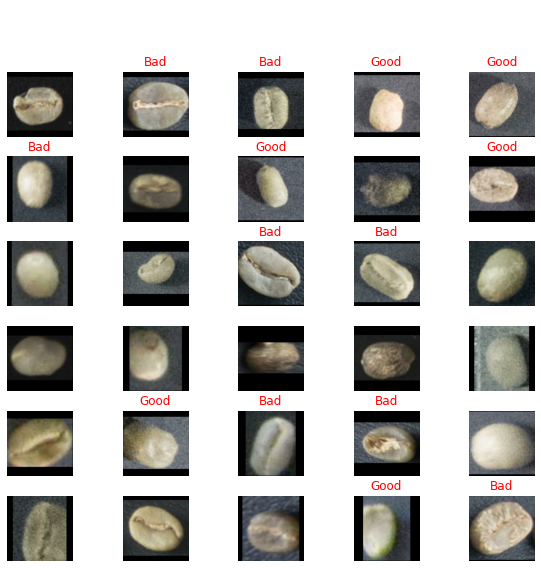

In [11]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n].astype(np.uint8))
  color = "white" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")